In [88]:
%load_ext autoreload
%autoreload 2


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import sys
import os
import time

from scipy.stats import t

#needed to import utils.py
sys.path.append('../') 

import utils
import utils_preprocessing
import utils_exec_models
import utils_exec_models_new

import numpy as np
import pandas as pd
#to view entire text of the comuns
pd.set_option('display.max_colwidth', None) 

import sklearn as sk

import tabulate

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import HTML

from IPython.display import clear_output

import pickle


from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
import imblearn.under_sampling as resus
import imblearn.ensemble as resemb
import imblearn.combine as reshyb
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier


%matplotlib inline  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Create instance for the best models

In [21]:
best_classifiers = []

# Decision Tree,Ensemble-Imbalance,All Features,Balanced Bagging,0.88,0.96,0.81,0.57,0.94,0.82,0.4,
estimator = DecisionTreeClassifier(class_weight='balanced',max_depth=4,random_state=42)
dt_ei = BalancedBaggingClassifier(
    estimator=estimator,
#     ':DecisionTreeClassifier(class_weight='balanced',max_depth=4,random_state=42),
    **{'n_estimators':7,'random_state':42,'replacement':True,'sampling_strategy':'all','warm_start':True}
)
best_classifiers.append(['Decision Tree (EI)', 'Ensemble-Imbalance', dt_ei])


# Neural Networks,Ensemble-Imbalance,All Features,Balanced Bagging,0.88,0.96,0.8,0.56,0.93,0.82,0.39,
estimator = MLPClassifier(activation='tanh',alpha=0.1,hidden_layer_sizes=30,learning_rate='adaptive',learning_rate_init=0.7,max_iter=2000,random_state=42)
nn_ei = BalancedBaggingClassifier(
    estimator=estimator,
    **{'n_estimators':101,'random_state':42,'replacement':True,'sampling_strategy':'auto','warm_start':False}
)
best_classifiers.append(['Neural Networks (EI)', 'Ensemble-Imbalance', nn_ei])


# Random Forest,Ensemble-Imbalance,All Features,Balanced Random Forest,0.87,0.96,0.79,0.55,0.93,0.81,0.38,
rf_ei = BalancedRandomForestClassifier(
    **{'criterion':'entropy','max_depth':7,'n_estimators':19,'random_state':42,'replacement':True,
       'sampling_strategy':'auto','warm_start':False}
)
best_classifiers.append(['Random Forest (EI)', 'Ensemble-Imbalance', rf_ei])

# SVM,Ensemble-Imbalance,All Features,Balanced Bagging,0.87,0.94,0.81,0.56,0.93,0.82,0.4,
estimator = SVC(C=3,class_weight='balanced',gamma='auto',probability=True,random_state=42)
svm_ei = BalancedBaggingClassifier(
    estimator=estimator,
    **{'n_estimators':51,'random_state':42,'replacement':False,'sampling_strategy':'auto','warm_start':True}
)
best_classifiers.append(['SVM (EI)', 'Ensemble-Imbalance', svm_ei])


# SVM,Single-Model,All Features,SVM,0.87,0.94,0.8,0.54,0.93,0.81,0.38,
svm_sm = SVC(
    **{'C':0.3,'class_weight':'balanced','gamma':'auto','kernel':'rbf','probability':True,'random_state':42}
)
best_classifiers.append(['SVM (SM)', 'Single-Model', svm_sm])

# Random Forest,Single-Model,All Features,Random Forest,0.87,0.89,0.86,0.6,0.92,0.86,0.46,
rf_sm = RandomForestClassifier(
    **{'class_weight':'balanced','criterion':'gini','max_depth':5,'n_estimators':51,'random_state':42}
)

best_classifiers.append(['Random Forest (SM)', 'Single-Model', rf_sm])


# Neural Networks,Single-Model,All Features,Neural Networks,0.87,0.87,0.87,0.61,0.94,0.87,0.47,
nn_sm = MLPClassifier(
    **{'activation':'tanh','alpha':0.3,'hidden_layer_sizes':(23,23,23),'learning_rate':'constant',
       'learning_rate_init':0.7,'max_iter':2000,'random_state':42,'solver':'sgd'}
)
best_classifiers.append(['Neural Networks (SM)', 'Single-Model', nn_sm])

# k-NN,Ensemble-Imbalance,All Features,Balanced Bagging,0.85,0.85,0.85,0.57,0.9,0.85,0.43,
estimator = KNeighborsClassifier(metric='euclidean',weights='distance')
knn_ei = BalancedBaggingClassifier(
    estimator=estimator,
    **{'n_estimators':101,'random_state':42,'replacement':True,'sampling_strategy':'all',
       'warm_start':True}
)
best_classifiers.append(['k-NN (EI)', 'Ensemble-Imbalance', knn_ei])

# Naïve Bayes,Ensemble-Imbalance,All Features,Balanced Bagging,0.84,0.85,0.83,0.54,0.9,0.83,0.4
estimator = GaussianNB()
nb_ei = BalancedBaggingClassifier(
    estimator = estimator,
    **{'n_estimators':31,'random_state':42,'replacement':True,'sampling_strategy':'all','warm_start':False}
)
best_classifiers.append(['Naïve Bayes (EI)', 'Ensemble-Imbalance', nb_ei])


# Decision Tree,Single-Model,All Features,Decision Tree,0.83,0.85,0.81,0.53,0.88,0.82,0.38,
dt_sm = DecisionTreeClassifier(
    **{'class_weight':'balanced','criterion':'gini','max_depth':4,'random_state':42}
)
best_classifiers.append(['Decision Tree (SM)', 'Single-Model', dt_sm])


# Naïve Bayes,Single-Model,All Features,Naïve Bayes,0.8,0.74,0.86,0.53,0.9,0.84,0.41,
nb_sm = GaussianNB()
best_classifiers.append(['Naïve Bayes (SM)', 'Single-Model', nb_sm])

# k-NN,Single-Model,All Features,k-NN,0.68,0.4,0.96,0.48,0.81,0.9,0.59,
knn_sm = KNeighborsClassifier(
    **{'metric':'manhattan','n_neighbors':3,'weights':'uniform'}
)
best_classifiers.append(['k-NN (SM)', 'Single-Model', knn_sm])


best_classifiers





[['Decision Tree (EI)',
  'Ensemble-Imbalance',
  BalancedBaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                             max_depth=4,
                                                             random_state=42),
                            n_estimators=7, random_state=42, replacement=True,
                            sampling_strategy='all', warm_start=True)],
 ['Neural Networks (EI)',
  'Ensemble-Imbalance',
  BalancedBaggingClassifier(estimator=MLPClassifier(activation='tanh', alpha=0.1,
                                                    hidden_layer_sizes=30,
                                                    learning_rate='adaptive',
                                                    learning_rate_init=0.7,
                                                    max_iter=2000,
                                                    random_state=42),
                            n_estimators=101, random_state=42, r

# Fit the models using CV and Training Data

In [47]:
CV_N_SPLITS = 5
CV_N_REPEATS = 3
RANDOM_STATE = 42

# CV strategy
cv = sk.model_selection.RepeatedStratifiedKFold(
    n_splits=CV_N_SPLITS, 
    n_repeats=CV_N_REPEATS, 
    random_state=RANDOM_STATE
)

# get train and tezt sets INCLUDING the Diagnosis_Delay feature
X_train, y_train, X_valid, y_valid = utils.get_train_and_validation_data(
    scaled=True,
    use_diagnosis_delay=True,
)


params = [
    {'classifier': [dt_ei]},
    {'classifier': [dt_sm]},
    {'classifier': [nn_ei]},
    {'classifier': [nn_sm]},
    {'classifier': [rf_ei]},
    {'classifier': [rf_sm]},
    {'classifier': [svm_ei]},
    {'classifier': [svm_sm]},
    {'classifier': [nb_ei]},
    {'classifier': [nb_sm]},
    {'classifier': [knn_ei]},
    {'classifier': [knn_ei]},
]

# auxiliary class
class DummyEstimator(sk.base.BaseEstimator):
        def fit(self): pass
        def score(self): pass
        
        
# Create a pipeline
# pipe = sk.pipeline.Pipeline([('classifier', DummyEstimator())])

pipeline = sk.pipeline.Pipeline(steps=[('classifier', GaussianNB() )])


grid = sk.model_selection.GridSearchCV(
    pipe, 
    param_grid=params, 
    scoring=utils_exec_models_new.get_default_scoring(), 
    cv=cv,
    n_jobs=9,
    verbose=2,
    refit='balanced_accuracy', 
)

grid.fit(X_train, y_train.values.ravel())


Fitting 15 folds for each of 12 candidates, totalling 180 fits
[CV] END classifier=BalancedBaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                           max_depth=4,
                                                           random_state=42),
                          n_estimators=7, random_state=42, replacement=True,
                          sampling_strategy='all', warm_start=True); total time=   0.0s
[CV] END classifier=BalancedBaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                           max_depth=4,
                                                           random_state=42),
                          n_estimators=7, random_state=42, replacement=True,
                          sampling_strategy='all', warm_start=True); total time=   0.0s
[CV] END classifier=BalancedBaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced

[CV] END classifier=BalancedBaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                           max_depth=4,
                                                           random_state=42),
                          n_estimators=7, random_state=42, replacement=True,
                          sampling_strategy='all', warm_start=True); total time=   0.0s
[CV] END classifier=BalancedBaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                           max_depth=4,
                                                           random_state=42),
                          n_estimators=7, random_state=42, replacement=True,
                          sampling_strategy='all', warm_start=True); total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42); total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(cla

[CV] END classifier=BalancedBaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                           max_depth=4,
                                                           random_state=42),
                          n_estimators=7, random_state=42, replacement=True,
                          sampling_strategy='all', warm_start=True); total time=   0.0s
[CV] END classifier=BalancedBaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                           max_depth=4,
                                                           random_state=42),
                          n_estimators=7, random_state=42, replacement=True,
                          sampling_strategy='all', warm_start=True); total time=   0.0s
[CV] END classifier=BalancedBaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                           m

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('classifier', DummyEstimator())]),
             n_jobs=9,
             param_grid=[{'classifier': [BalancedBaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                                    max_depth=4,
                                                                                                    random_state=42),
                                                                   n_estimators=7,
                                                                   random_state=42,
                                                                   replacement=True,
                                                                   sampling_strat...
             refit='balanced_accuracy',
             scoring={'accuracy': make_scorer(accuracy_score), 'auc': 'roc_auc',
                      'balanced_accuracy': make_scorer(balanced_accuracy_score),
                      'f1': make_scorer(f1_score, zero_division=0.0),
                      'precision': make_scorer(precision_score, zero_division=0),
                      'sensitivity': make_scorer(recall_score),
                      'specificity': make_scorer(recall_score, pos_label=0)},
             verbose=2)


# Statistical comparison of models using grid search

This example illustrates how to statistically compare the performance of models
trained and evaluated using :class:`~sklearn.model_selection.GridSearchCV`.


# 1) Create dataFrame with the all "cv_results_" of all algorithm and scenarios

In [53]:
df_results = pd.DataFrame(grid.cv_results_)


df_results.insert(0, 'Algorithm', [
    'Decision Tree (EI)',
    'Decision Tree',
    'Neural Networks (EI)',
    'Neural Networks',
    'Random Forest (EI)',
    'Random Forest',
    'SVM (EI)',
    'SVM',
    'Naïve Bayes (EI)',
    'Naïve Bayes',
    'k-NN (EI)',
    'k-NN',
])

df_results




,Algorithm,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,params,split0_test_balanced_accuracy,split1_test_balanced_accuracy,split2_test_balanced_accuracy,...,split8_test_precision,split9_test_precision,split10_test_precision,split11_test_precision,split12_test_precision,split13_test_precision,split14_test_precision,mean_test_precision,std_test_precision,rank_test_precision
0,Decision Tree (EI),0.020378,0.004510,0.010557,0.001908,"BalancedBaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',\n max_depth=4,\n random_state=42),\n n_estimators=7, random_state=42, replacement=True,\n sampling_strategy='all', warm_start=True)","{'classifier': BalancedBaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42), n_estimators=7, random_state=42, replacement=True, sampling_strategy='all', warm_start=True)}",0.789790,0.780087,0.745327,...,0.405797,0.436620,0.376623,0.397260,0.397260,0.483871,0.378378,0.406411,0.031863,9
1,Decision Tree,0.003076,0.000651,0.009164,0.002207,"DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42)","{'classifier': DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42)}",0.801495,0.770963,0.703267,...,0.302752,0.263636,0.348485,0.394366,0.317308,0.330097,0.300971,0.332035,0.029886,11
2,Neural Networks (EI),1.864247,0.391601,0.033194,0.007292,"BalancedBaggingClassifier(estimator=MLPClassifier(activation='tanh', alpha=0.1,\n hidden_layer_sizes=30,\n learning_rate='adaptive',\n learning_rate_init=0.7,\n max_iter=2000,\n random_state=42),\n n_estimators=101, random_state=42, replacement=True)","{'classifier': BalancedBaggingClassifier(estimator=MLPClassifier(activation='tanh', alpha=0.1, hidden_layer_sizes=30, learning_rate='adaptive', learning_rate_init=0.7, max_iter=2000, random_state=42), n_estimators=101, random_state=42, replacement=True)}",0.847116,0.837992,0.764821,...,0.455696,0.430380,0.441558,0.390244,0.395062,0.514706,0.407895,0.423085,0.040160,6
3,Neural Networks,0.031136,0.007931,0.008507,0.001938,"MLPClassifier(activation='tanh', alpha=0.3, hidden_layer_sizes=(23, 23, 23),\n learning_rate_init=0.7, max_iter=2000, random_state=42,\n solver='sgd')","{'classifier': MLPClassifier(activation='tanh', alpha=0.3, hidden_layer_sizes=(23, 23, 23), learning_rate_init=0.7, max_iter=2000, random_state=42, solver='sgd')}",0.500000,0.500000,0.500000,...,0.127389,0.000000,0.130159,0.000000,0.000000,0.000000,0.000000,0.034524,0.057255,12
4,Random Forest (EI),0.028014,0.000898,0.009741,0.000354,"BalancedRandomForestClassifier(criterion='entropy', max_depth=7,\n n_estimators=19, random_state=42,\n replacement=True, sampling_strategy='auto')","{'classifier': BalancedRandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=19, random_state=42, replacement=True, sampling_strategy='auto')}",0.783158,0.836167,0.764821,...,0.381443,0.409639,0.459459,0.383721,0.402597,0.500000,0.372340,0.399383,0.046772,10
5,Random Forest,0.044686,0.001346,0.012860,0.000843,"RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=51,\n random_state=42)","{'classifier': RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=51, random_state=42)}",0.797089,0.819655,0.773945,...,0.471429,0.484375,0.534483,0.405797,0.422535,0.565217,0.460317,0.467150,0.044355,2
6,SVM (EI),0.677025,0.147612,0.258191,0.044774,"BalancedBaggingClassifier(estimator=SVC(C=3, class_weight='balanced',\n gamma='auto', probability=True,\n random_state=42),\n n_estimators=51, random_state=42, warm_start=True)","{'classifier': BalancedBaggingClassifier(estimator=SVC(C=3, class_weight='balanced', gamma='auto', probability=True, random_state=42), n_estimators=51, random_state=42, warm_start=True)}",0.850766,0.856240,0.764821,...,0.456790,0.428571,0.465753,0.385542,0.424658,0.530303,0.424658,0.442610,0.043964,3
7,SVM,0.155306,0.003799,0.028643,0.001627,"SVC(C=0.3, class_weight='balanced',

# Plot performance by each CV split CV test fold 

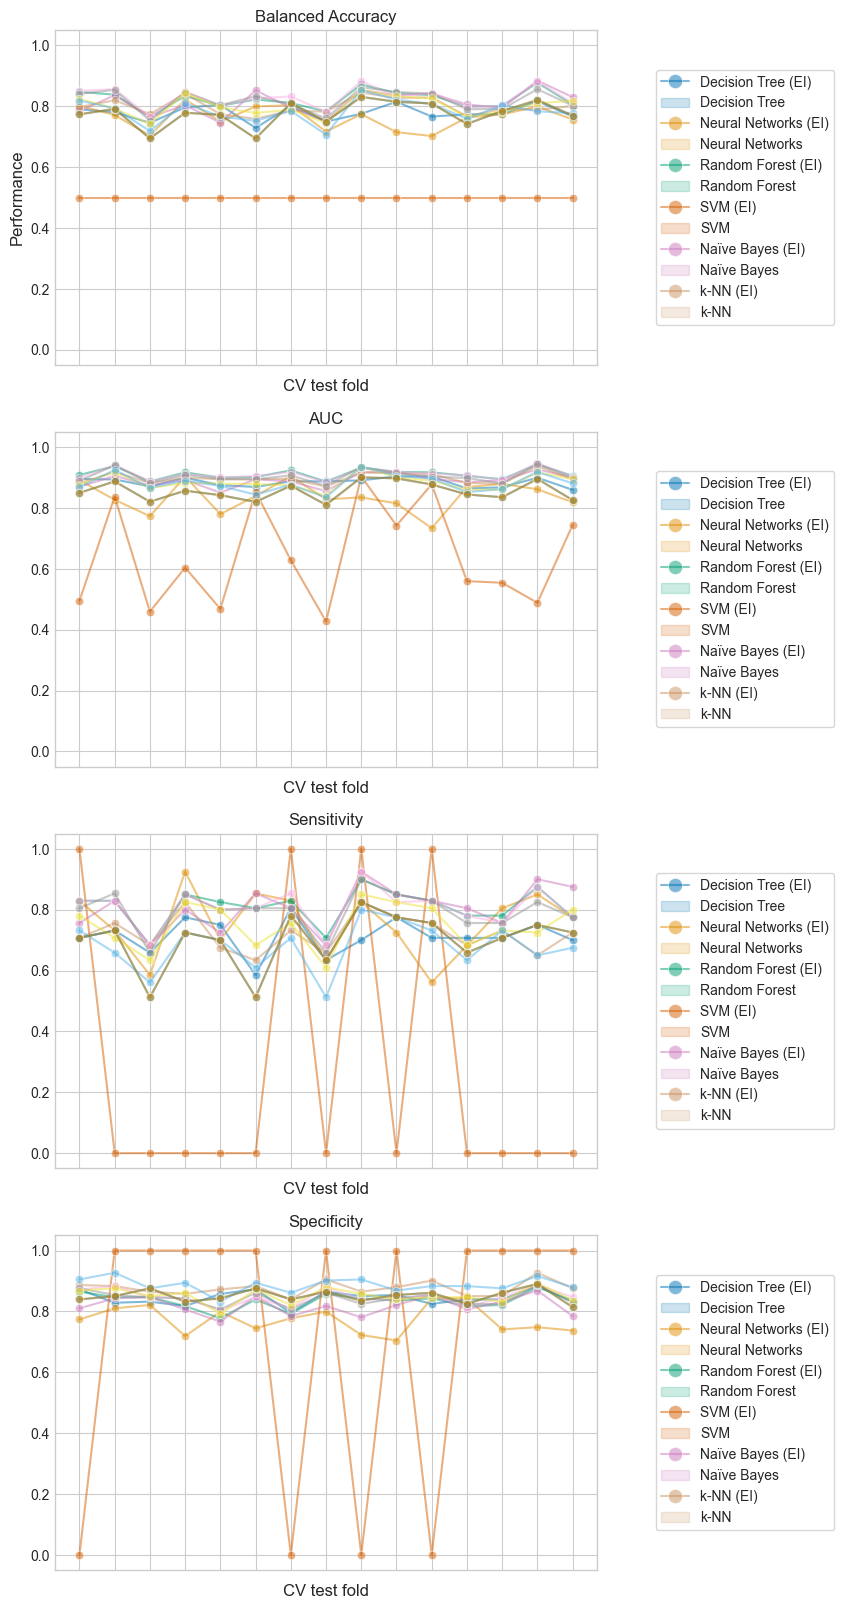

In [61]:
results_df = df_results.copy()



# plot 30 examples of dependency between cv fold and AUC scores
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    4,1,
    figsize=(7,20), 
    sharex=False, 
    sharey=True
)

# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_balanced_accuracy")

g = sns.lineplot(
    ax=ax1,
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="colorblind",
    marker="o",
    alpha=0.5,
)
ax1.set_xlabel("CV test fold", size=12, labelpad=10)
ax1.set_ylabel("Performance", size=12)
ax1.tick_params(bottom=True, labelbottom=False)
ax1.set_title('Balanced Accuracy')

ax1.legend(results_df.Algorithm.values)
sns.move_legend(g, "center right", bbox_to_anchor=(1.45, 0.5), frameon=True, markerscale=1.7,)


# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_auc")
g = sns.lineplot(
    ax=ax2,
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="colorblind",
    marker="o",
    alpha=0.5,
)
ax2.set_xlabel("CV test fold", size=12, labelpad=10)
ax2.tick_params(bottom=True, labelbottom=False)
ax2.set_title('AUC')

ax2.legend(results_df.Algorithm.values)
sns.move_legend(g, "center right", bbox_to_anchor=(1.45, 0.5), frameon=True, markerscale=1.7,)


# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_sensitivity")
g = sns.lineplot(
    ax=ax3,
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="colorblind",
    marker="o",
    alpha=0.5,
)
ax3.set_xlabel("CV test fold", size=12, labelpad=10)
ax3.tick_params(bottom=True, labelbottom=False)
ax3.set_title('Sensitivity')

ax3.legend(results_df.Algorithm.values)
sns.move_legend(g, "center right", bbox_to_anchor=(1.45, 0.5), frameon=True, markerscale=1.7,)


# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_specificity")
g = sns.lineplot(
    ax=ax4,
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="colorblind",
    marker="o",
    alpha=0.5,
)
ax4.set_xlabel("CV test fold", size=12, labelpad=10)
ax4.tick_params(bottom=True, labelbottom=False)
ax4.set_title('Specificity')

ax4.legend(results_df.Algorithm.values)
sns.move_legend(g, "center right", bbox_to_anchor=(1.45, 0.5), frameon=True, markerscale=1.7,)


plt.show()

# # print correlation of Bal Acc scores across folds
# print(f"Correlation of models:")
# df_corr = pd.DataFrame(model_scores.transpose().corr())
# # display(df_corr)
# sns.heatmap(data=df_corr)

# Implement Bonferroni correction

In [95]:
from itertools import combinations
from math import factorial





# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_balanced_accuracy")

n_comparisons = factorial(len(model_scores)) / (
    factorial(2) * factorial(len(model_scores) - 2)
)
pairwise_t_test = []

for model_i, model_k in combinations(range(len(model_scores)), 2):
    model_i_scores = model_scores.iloc[model_i].values
    model_k_scores = model_scores.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    
    n = differences.shape[0]  # number of test sets
    df = n - 1
    
    # 5-fold: qty of rows by train and test sets 
    n_train = len(list(cv.split(X_train, y_train))[0][0])
    n_test = len(list(cv.split(X_train, y_train))[0][1])

#     print(differences, df, n_train, n_test)
    
    t_stat, p_val = utils_exec_models_new.compute_corrected_ttest(differences, df, n_train, n_test)
    p_val *= n_comparisons  # implement Bonferroni correction
    # Bonferroni can output p-values higher than 1
    p_val = 1 if p_val > 1 else p_val
    pairwise_t_test.append(
        [model_scores.index[model_i], model_scores.index[model_k], t_stat, p_val]
    )

pairwise_comp_df = pd.DataFrame(
    pairwise_t_test, columns=["model_1", "model_2", "t_stat", "p_val"]
).round(3)

print(pairwise_comp_df.to_markdown()) #.loc[(pairwise_comp_df.p_val < 0.05)]

# print(tabulate(pairwise_comp_df, headers='keys', tablefmt='psql'))

|    | model_1              | model_2              |   t_stat |   p_val |
|---:|:---------------------|:---------------------|---------:|--------:|
|  0 | Decision Tree (EI)   | Decision Tree        |    0.68  |   1     |
|  1 | Decision Tree (EI)   | Neural Networks (EI) |   -2.708 |   0.561 |
|  2 | Decision Tree (EI)   | Neural Networks      |   19.419 |   0     |
|  3 | Decision Tree (EI)   | Random Forest (EI)   |   -1.307 |   1     |
|  4 | Decision Tree (EI)   | Random Forest        |   -1.175 |   1     |
|  5 | Decision Tree (EI)   | SVM (EI)             |   -2.748 |   0.518 |
|  6 | Decision Tree (EI)   | SVM                  |   -2.198 |   1     |
|  7 | Decision Tree (EI)   | Naïve Bayes (EI)     |   -1.251 |   1     |
|  8 | Decision Tree (EI)   | Naïve Bayes          |   -0.261 |   1     |
|  9 | Decision Tree (EI)   | k-NN (EI)            |    0.197 |   1     |
| 10 | Decision Tree (EI)   | k-NN                 |    0.197 |   1     |
| 11 | Decision Tree        | Neural N

In [96]:
pairwise_bayesian = []

for model_i, model_k in combinations(range(len(model_scores)), 2):
    model_i_scores = model_scores.iloc[model_i].values
    model_k_scores = model_scores.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    t_post = t(
        df, loc=np.mean(differences), scale=utils_exec_models_new.corrected_std(differences, n_train, n_test)
    )
    worse_prob = t_post.cdf(rope_interval[0])
    better_prob = 1 - t_post.cdf(rope_interval[1])
    rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

    pairwise_bayesian.append([worse_prob, better_prob, rope_prob])

pairwise_bayesian_df = pd.DataFrame(
    pairwise_bayesian, columns=["worse_prob", "better_prob", "rope_prob"]
).round(3)

pairwise_comp_df = pairwise_comp_df.join(pairwise_bayesian_df)
pairwise_comp_df

/home/papaiz/anaconda3/envs/phd/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2066: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


,model_1,model_2,t_stat,p_val,worse_prob,better_prob,rope_prob
0,Decision Tree (EI),Decision Tree,0.680,1.000,0.140,0.593,0.267
1,Decision Tree (EI),Neural Networks (EI),-2.708,0.561,0.972,0.002,0.025
2,Decision Tree (EI),Neural Networks,19.419,0.000,0.000,1.000,0.000
3,Decision Tree (EI),Random Forest (EI),-1.307,1.000,0.811,0.055,0.133
4,Decision Tree (EI),Random Forest,-1.175,1.000,0.717,0.050,0.233
...,...,...,...,...,...,...,...
61,Naïve Bayes (EI),k-NN (EI),1.436,1.000,0.031,0.793,0.176
62,Naïve Bayes (EI),k-NN,1.436,1.000,0.031,0.793,0.176
63,Naïve Bayes,k-NN (EI),0.511,1.000,0.137,0.453,0.410
64,Naïve Bayes,k-NN,0.511,1.000,0.137,0.453,0.410


## Comparing two models: frequentist approach

We can start by asking: "Is the first model significantly better than the
second model (when ranked by `mean_test_score`)?"

To answer this question using a frequentist approach we could
run a paired t-test and compute the p-value. This is also known as
Diebold-Mariano test in the forecast literature [5]_.
Many variants of such a t-test have been developed to account for the
'non-independence of samples problem'
described in the previous section. We will use the one proven to obtain the
highest replicability scores (which rate how similar the performance of a
model is when evaluating it on different random partitions of the same
dataset) while maintaining a low rate of false positives and false negatives:
the Nadeau and Bengio's corrected t-test [2]_ that uses a 10 times repeated
10-fold cross validation [3]_.

This corrected paired t-test is computed as:

\begin{align}t=\frac{\frac{1}{k \cdot r}\sum_{i=1}^{k}\sum_{j=1}^{r}x_{ij}}
   {\sqrt{(\frac{1}{k \cdot r}+\frac{n_{test}}{n_{train}})\hat{\sigma}^2}}\end{align}

where $k$ is the number of folds,
$r$ the number of repetitions in the cross-validation,
$x$ is the difference in performance of the models,
$n_{test}$ is the number of samples used for testing,
$n_{train}$ is the number of samples used for training,
and $\hat{\sigma}^2$ represents the variance of the observed
differences.

Let's implement a corrected right-tailed paired t-test to evaluate if the
performance of the first model is significantly better than that of the
second model. Our null hypothesis is that the second model performs at least
as good as the first model.



In [112]:
import numpy as np
from scipy.stats import t


def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : float
        Variance-corrected standard deviation of the set of differences.
    """
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std


def compute_corrected_ttest(differences, df, n_train, n_test):
    """Computes right-tailed paired t-test with corrected variance.

    Parameters
    ----------
    differences : array-like of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    df : int
        Degrees of freedom.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_val : float
        Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    
    if std ==0:
        std = 0.001
        
    t_stat = mean / std
    p_val = t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

In [113]:
results_df[["params", "mean_test_balanced_accuracy", "std_test_balanced_accuracy"]]

,params,mean_test_balanced_accuracy,std_test_balanced_accuracy
Algorithm,,,
Decision Tree (EI),"{'classifier': BalancedBaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42), n_estimators=7, random_state=42, replacement=True, sampling_strategy='all', warm_start=True)}",0.778605,0.024615
Decision Tree,"{'classifier': DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42)}",0.763205,0.037823
Neural Networks (EI),"{'classifier': BalancedBaggingClassifier(estimator=MLPClassifier(activation='tanh', alpha=0.1, hidden_layer_sizes=30, learning_rate='adaptive', learning_rate_init=0.7, max_iter=2000, random_state=42), n_estimators=101, random_state=42, replacement=True)}",0.822214,0.030350
Neural Networks,"{'classifier': MLPClassifier(activation='tanh', alpha=0.3, hidden_layer_sizes=(23, 23, 23), learning_rate_init=0.7, max_iter=2000, random_state=42, solver='sgd')}",0.500000,0.000000
Random Forest (EI),"{'classifier': BalancedRandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=19, random_state=42, replacement=True, sampling_strategy='auto')}",0.811624,0.039027
Random Forest,"{'classifier': RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=51, random_state=42)}",0.798627,0.026604
SVM (EI),"{'classifier': BalancedBaggingClassifier(estimator=SVC(C=3, class_weight='balanced', gamma='auto', probability=True, random_state=42), n_estimators=51, random_state=42, warm_start=True)}",0.827137,0.033165
SVM,"{'classifier': SVC(C=0.3, class_weight='balanced', gamma='auto', probability=True, random_state=42)}",0.818972,0.034052
Naïve Bayes (EI),"{'classifier': BalancedBaggingClassifier(estimator=GaussianNB(), n_estimators=31, random_state=42, replacement=True, sampling_strategy='all')}",0.799632,0.032818


In [114]:
model_1_scores = model_scores.iloc[0].values  # scores of the best model
model_2_scores = model_scores.iloc[1].values  # scores of the second-best model

differences = model_1_scores - model_2_scores

n = differences.shape[0]  # number of test sets
df = n - 1
n_train = len(list(cv.split(X_train, y_train))[0][0])
n_test = len(list(cv.split(X_train, y_train))[0][1])

t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
print(f"Corrected t-value: {t_stat:.3f}\nCorrected p-value: {p_val:.3f}")

Corrected t-value: 0.680
Corrected p-value: 0.254


We can compare the corrected t- and p-values with the uncorrected ones:



In [115]:
t_stat_uncorrected = np.mean(differences) / np.sqrt(np.var(differences, ddof=1) / n)
p_val_uncorrected = t.sf(np.abs(t_stat_uncorrected), df)

print(
    f"Uncorrected t-value: {t_stat_uncorrected:.3f}\n"
    f"Uncorrected p-value: {p_val_uncorrected:.3f}"
)

Uncorrected t-value: 1.483
Uncorrected p-value: 0.080


Using the conventional significance alpha level at `p=0.05`, we observe that
the uncorrected t-test concludes that the first model is significantly better
than the second.

With the corrected approach, in contrast, we fail to detect this difference.

In the latter case, however, the frequentist approach does not let us
conclude that the first and second model have an equivalent performance. If
we wanted to make this assertion we need to use a Bayesian approach.



## Comparing two models: Bayesian approach
We can use Bayesian estimation to calculate the probability that the first
model is better than the second. Bayesian estimation will output a
distribution followed by the mean $\mu$ of the differences in the
performance of two models.

To obtain the posterior distribution we need to define a prior that models
our beliefs of how the mean is distributed before looking at the data,
and multiply it by a likelihood function that computes how likely our
observed differences are, given the values that the mean of differences
could take.

Bayesian estimation can be carried out in many forms to answer our question,
but in this example we will implement the approach suggested by Benavoli and
colleagues [4]_.

One way of defining our posterior using a closed-form expression is to select
a prior conjugate to the likelihood function. Benavoli and colleagues [4]_
show that when comparing the performance of two classifiers we can model the
prior as a Normal-Gamma distribution (with both mean and variance unknown)
conjugate to a normal likelihood, to thus express the posterior as a normal
distribution.
Marginalizing out the variance from this normal posterior, we can define the
posterior of the mean parameter as a Student's t-distribution. Specifically:

\begin{align}St(\mu;n-1,\overline{x},(\frac{1}{n}+\frac{n_{test}}{n_{train}})
   \hat{\sigma}^2)\end{align}

where $n$ is the total number of samples,
$\overline{x}$ represents the mean difference in the scores,
$n_{test}$ is the number of samples used for testing,
$n_{train}$ is the number of samples used for training,
and $\hat{\sigma}^2$ represents the variance of the observed
differences.

Notice that we are using Nadeau and Bengio's corrected variance in our
Bayesian approach as well.

Let's compute and plot the posterior:



In [116]:
# initialize random variable
t_post = t(
    df, 
    loc=np.mean(differences), 
    scale=utils_exec_models_new.corrected_std(differences, n_train, n_test)
)
t_post

Let's plot the posterior distribution:



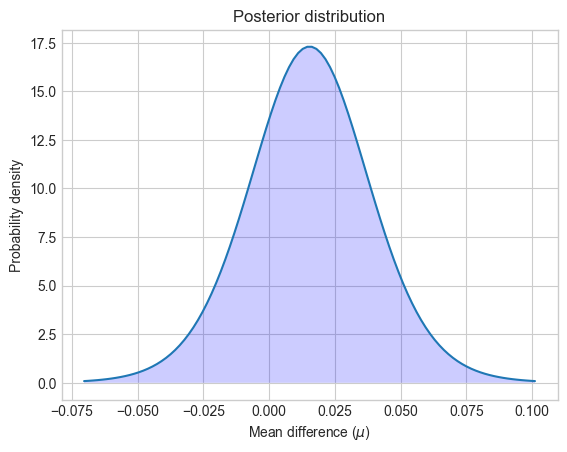

In [117]:
x = np.linspace(t_post.ppf(0.001), t_post.ppf(0.999), 100)

plt.plot(x, t_post.pdf(x))
# plt.xticks(np.arange(-0.04, 0.06, 0.01))
plt.fill_between(x, t_post.pdf(x), 0, facecolor="blue", alpha=0.2)
plt.ylabel("Probability density")
plt.xlabel(r"Mean difference ($\mu$)")
plt.title("Posterior distribution")
plt.show()

We can calculate the probability that the first model is better than the
second by computing the area under the curve of the posterior distribution
from zero to infinity. And also the reverse: we can calculate the probability
that the second model is better than the first by computing the area under
the curve from minus infinity to zero.



In [118]:
better_prob = 1 - t_post.cdf(0)

print(
    f"Probability of {model_scores.index[0]} being more accurate than "
    f"{model_scores.index[1]}: {better_prob:.3f}"
)
print(
    f"Probability of {model_scores.index[1]} being more accurate than "
    f"{model_scores.index[0]}: {1 - better_prob:.3f}"
)

Probability of Decision Tree (EI) being more accurate than Decision Tree: 0.746
Probability of Decision Tree being more accurate than Decision Tree (EI): 0.254


In contrast with the frequentist approach, we can compute the probability
that one model is better than the other.

Note that we obtained similar results as those in the frequentist approach.
Given our choice of priors, we are essentially performing the same
computations, but we are allowed to make different assertions.



### Region of Practical Equivalence
Sometimes we are interested in determining the probabilities that our models
have an equivalent performance, where "equivalent" is defined in a practical
way. A naive approach [4]_ would be to define estimators as practically
equivalent when they differ by less than 1% in their accuracy. But we could
also define this practical equivalence taking into account the problem we are
trying to solve. For example, a difference of 5% in accuracy would mean an
increase of $1000 in sales, and we consider any quantity above that as
relevant for our business.

In this example we are going to define the
Region of Practical Equivalence (ROPE) to be $[-0.01, 0.01]$. That is,
we will consider two models as practically equivalent if they differ by less
than 1% in their performance.

To compute the probabilities of the classifiers being practically equivalent,
we calculate the area under the curve of the posterior over the ROPE
interval:



In [119]:
rope_interval = [-0.01, 0.01]
rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

print(
    f"Probability of {model_scores.index[0]} and {model_scores.index[1]} "
    f"\n being practically equivalent: {rope_prob:.3f}"
)

Probability of Decision Tree (EI) and Decision Tree 
 being practically equivalent: 0.267


We can plot how the posterior is distributed over the ROPE interval:



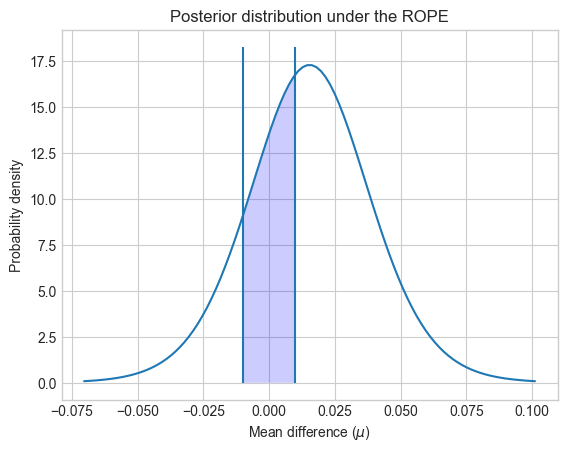

In [120]:
x_rope = np.linspace(rope_interval[0], rope_interval[1], 100)

plt.plot(x, t_post.pdf(x))
# plt.xticks(np.arange(-0.04, 0.06, 0.01))
plt.vlines([-0.01, 0.01], ymin=0, ymax=(np.max(t_post.pdf(x)) + 1))
plt.fill_between(x_rope, t_post.pdf(x_rope), 0, facecolor="blue", alpha=0.2)
plt.ylabel("Probability density")
plt.xlabel(r"Mean difference ($\mu$)")
plt.title("Posterior distribution under the ROPE")
plt.show()

As suggested in [4]_, we can further interpret these probabilities using the
same criteria as the frequentist approach: is the probability of falling
inside the ROPE bigger than 95% (alpha value of 5%)?  In that case we can
conclude that both models are practically equivalent.



The Bayesian estimation approach also allows us to compute how uncertain we
are about our estimation of the difference. This can be calculated using
credible intervals. For a given probability, they show the range of values
that the estimated quantity, in our case the mean difference in
performance, can take.
For example, a 50% credible interval [x, y] tells us that there is a 50%
probability that the true (mean) difference of performance between models is
between x and y.

Let's determine the credible intervals of our data using 50%, 75% and 95%:



In [121]:
cred_intervals = []
intervals = [0.5, 0.75, 0.95]

for interval in intervals:
    cred_interval = list(t_post.interval(interval))
    cred_intervals.append([interval, cred_interval[0], cred_interval[1]])

cred_int_df = pd.DataFrame(
    cred_intervals, columns=["interval", "lower value", "upper value"]
).set_index("interval")
cred_int_df

,lower value,upper value
interval,,
0.50,-0.000279,0.031079
0.75,-0.011775,0.042575
0.95,-0.033165,0.063965


As shown in the table, there is a 50% probability that the true mean
difference between models will be between 0.000977 and 0.019023, 70%
probability that it will be between -0.005422 and 0.025422, and 95%
probability that it will be between -0.016445	and 0.036445.



## Pairwise comparison of all models: frequentist approach

We could also be interested in comparing the performance of all our models
evaluated with :class:`~sklearn.model_selection.GridSearchCV`. In this case
we would be running our statistical test multiple times, which leads us to
the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem).

There are many possible ways to tackle this problem, but a standard approach
is to apply a [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction). Bonferroni can be
computed by multiplying the p-value by the number of comparisons we are
testing.

Let's compare the performance of the models using the corrected t-test:



In [130]:
from itertools import combinations
from math import factorial

results_df = df_results.copy()

results_df.set_index('Algorithm', inplace=True)

model_scores = results_df.filter(regex=r"split\d*_test_balanced_accuracy")

n_comparisons = factorial(len(model_scores)) / (
    factorial(2) * factorial(len(model_scores) - 2)
)
pairwise_t_test = []

for model_i, model_k in combinations(range(len(model_scores)), 2):
    model_i_scores = model_scores.iloc[model_i].values
    model_k_scores = model_scores.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    t_stat, p_val = utils_exec_models_new.compute_corrected_ttest(differences, df, n_train, n_test)
    p_val *= n_comparisons  # implement Bonferroni correction
    # Bonferroni can output p-values higher than 1
    p_val = 1 if p_val > 1 else p_val
    pairwise_t_test.append(
        [model_scores.index[model_i], model_scores.index[model_k], t_stat, p_val]
    )

   
pairwise_comp_df = pd.DataFrame(
    pairwise_t_test, columns=["model_1", "model_2", "t_stat", "p_val"]
).round(3)

print(pairwise_comp_df.to_markdown()) #.loc[(pairwise_comp_df.p_val < 0.05)]

|    | model_1              | model_2              |   t_stat |   p_val |
|---:|:---------------------|:---------------------|---------:|--------:|
|  0 | Decision Tree (EI)   | Decision Tree        |    0.68  |   1     |
|  1 | Decision Tree (EI)   | Neural Networks (EI) |   -2.708 |   0.561 |
|  2 | Decision Tree (EI)   | Neural Networks      |   19.419 |   0     |
|  3 | Decision Tree (EI)   | Random Forest (EI)   |   -1.307 |   1     |
|  4 | Decision Tree (EI)   | Random Forest        |   -1.175 |   1     |
|  5 | Decision Tree (EI)   | SVM (EI)             |   -2.748 |   0.518 |
|  6 | Decision Tree (EI)   | SVM                  |   -2.198 |   1     |
|  7 | Decision Tree (EI)   | Naïve Bayes (EI)     |   -1.251 |   1     |
|  8 | Decision Tree (EI)   | Naïve Bayes          |   -0.261 |   1     |
|  9 | Decision Tree (EI)   | k-NN (EI)            |    0.197 |   1     |
| 10 | Decision Tree (EI)   | k-NN                 |    0.197 |   1     |
| 11 | Decision Tree        | Neural N

We observe that after correcting for multiple comparisons, the only model
that significantly differs from the others is `'2_poly'`.
`'rbf'`, the model ranked first by
:class:`~sklearn.model_selection.GridSearchCV`, does not significantly
differ from `'linear'` or `'3_poly'`.



## Pairwise comparison of all models: Bayesian approach

When using Bayesian estimation to compare multiple models, we don't need to
correct for multiple comparisons (for reasons why see [4]_).

We can carry out our pairwise comparisons the same way as in the first
section:



In [131]:
pairwise_bayesian = []

for model_i, model_k in combinations(range(len(model_scores)), 2):
    model_i_scores = model_scores.iloc[model_i].values
    model_k_scores = model_scores.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    t_post = t(
        df, loc=np.mean(differences), scale=corrected_std(differences, n_train, n_test)
    )
    worse_prob = t_post.cdf(rope_interval[0])
    better_prob = 1 - t_post.cdf(rope_interval[1])
    rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

    pairwise_bayesian.append([worse_prob, better_prob, rope_prob])

pairwise_bayesian_df = pd.DataFrame(
    pairwise_bayesian, columns=["worse_prob", "better_prob", "rope_prob"]
).round(3)

pairwise_comp_df = pairwise_comp_df.join(pairwise_bayesian_df)

print(pairwise_comp_df.to_markdown()) #.loc[(pairwise_comp_df.p_val < 0.05)]

|    | model_1              | model_2              |   t_stat |   p_val |   worse_prob |   better_prob |   rope_prob |
|---:|:---------------------|:---------------------|---------:|--------:|-------------:|--------------:|------------:|
|  0 | Decision Tree (EI)   | Decision Tree        |    0.68  |   1     |        0.14  |         0.593 |       0.267 |
|  1 | Decision Tree (EI)   | Neural Networks (EI) |   -2.708 |   0.561 |        0.972 |         0.002 |       0.025 |
|  2 | Decision Tree (EI)   | Neural Networks      |   19.419 |   0     |        0     |         1     |       0     |
|  3 | Decision Tree (EI)   | Random Forest (EI)   |   -1.307 |   1     |        0.811 |         0.055 |       0.133 |
|  4 | Decision Tree (EI)   | Random Forest        |   -1.175 |   1     |        0.717 |         0.05  |       0.233 |
|  5 | Decision Tree (EI)   | SVM (EI)             |   -2.748 |   0.518 |        0.977 |         0.003 |       0.021 |
|  6 | Decision Tree (EI)   | SVM               

/home/papaiz/anaconda3/envs/phd/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2066: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


Using the Bayesian approach we can compute the probability that a model
performs better, worse or practically equivalent to another.

Results show that the model ranked first by
:class:`~sklearn.model_selection.GridSearchCV` `'rbf'`, has approximately a
6.8% chance of being worse than `'linear'`, and a 1.8% chance of being worse
than `'3_poly'`.
`'rbf'` and `'linear'` have a 43% probability of being practically
equivalent, while `'rbf'` and `'3_poly'` have a 10% chance of being so.

Similarly to the conclusions obtained using the frequentist approach, all
models have a 100% probability of being better than `'2_poly'`, and none have
a practically equivalent performance with the latter.



## Take-home messages
- Small differences in performance measures might easily turn out to be
  merely by chance, but not because one model predicts systematically better
  than the other. As shown in this example, statistics can tell you how
  likely that is.
- When statistically comparing the performance of two models evaluated in
  GridSearchCV, it is necessary to correct the calculated variance which
  could be underestimated since the scores of the models are not independent
  from each other.
- A frequentist approach that uses a (variance-corrected) paired t-test can
  tell us if the performance of one model is better than another with a
  degree of certainty above chance.
- A Bayesian approach can provide the probabilities of one model being
  better, worse or practically equivalent than another. It can also tell us
  how confident we are of knowing that the true differences of our models
  fall under a certain range of values.
- If multiple models are statistically compared, a multiple comparisons
  correction is needed when using the frequentist approach.



.. topic:: References

   .. [1] Dietterich, T. G. (1998). [Approximate statistical tests for
          comparing supervised classification learning algorithms](http://web.cs.iastate.edu/~jtian/cs573/Papers/Dietterich-98.pdf).
          Neural computation, 10(7).
   .. [2] Nadeau, C., & Bengio, Y. (2000). [Inference for the generalization
          error](https://papers.nips.cc/paper/1661-inference-for-the-generalization-error.pdf).
          In Advances in neural information processing systems.
   .. [3] Bouckaert, R. R., & Frank, E. (2004). [Evaluating the replicability
          of significance tests for comparing learning algorithms](https://www.cms.waikato.ac.nz/~ml/publications/2004/bouckaert-frank.pdf).
          In Pacific-Asia Conference on Knowledge Discovery and Data Mining.
   .. [4] Benavoli, A., Corani, G., Demšar, J., & Zaffalon, M. (2017). [Time
          for a change: a tutorial for comparing multiple classifiers through
          Bayesian analysis](http://www.jmlr.org/papers/volume18/16-305/16-305.pdf).
          The Journal of Machine Learning Research, 18(1). See the Python
          library that accompanies this paper [here](https://github.com/janezd/baycomp).
   .. [5] Diebold, F.X. & Mariano R.S. (1995). [Comparing predictive accuracy](http://www.est.uc3m.es/esp/nueva_docencia/comp_col_get/lade/tecnicas_prediccion/Practicas0708/Comparing%20Predictive%20Accuracy%20(Dielbold).pdf)
          Journal of Business & economic statistics, 20(1), 134-144.

